# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  


**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

/Users/tiffanyflor/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv',index_col=0)

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
cigData.head()

,Time,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [4]:
cigData.columns

Index(['Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [5]:
cigData.dtypes

Time         object
#CigSales     int64
dtype: object

Check whether there are any null values. 

In [6]:
cigData.isnull().values.any()

False

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [7]:
# Already done using index_col above

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [8]:
cigData.rename(columns={'Time':'Month'},inplace=True)

Call a head() to check this has worked. 

In [9]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


In [10]:
cigData.tail()

,Month,#CigSales
139,1960-08,1000606
140,1960-09,1000508
141,1960-10,1000461
142,1960-11,1000390
143,1960-12,1000432


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [11]:
cigData['Month']=pd.to_datetime(cigData['Month'])

In [12]:
cigData.dtypes

Month        datetime64[ns]
#CigSales             int64
dtype: object

In [13]:
cigData = cigData.set_index('Month')
cigData.head()

,#CigSales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #CigSales column. 

In [14]:
y=cigData['#CigSales'].resample('M').sum()

In [15]:
y.isnull().sum()

0

Check the type of our new variable. 

In [16]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [17]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

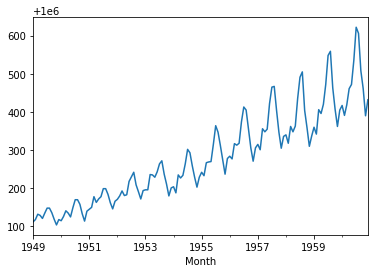

In [18]:
y.plot()

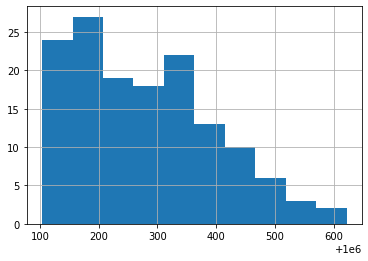

In [19]:
y.hist()

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

In [20]:
decomp = seasonal_decompose(y, model='multiplicative')

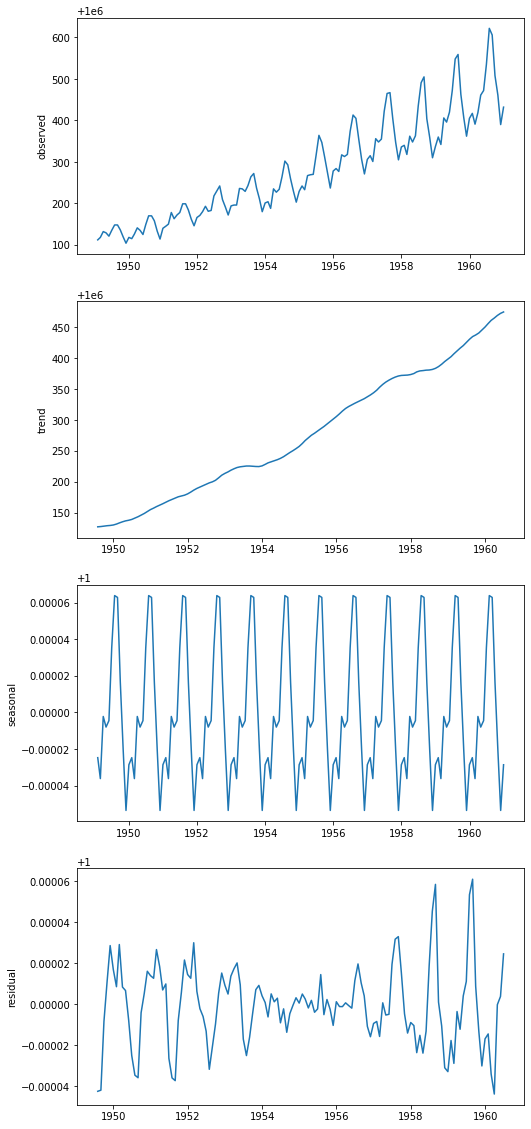

In [21]:
# Plot the original data, the trend, the seasonality, and the residuals 
fig, ax = plt.subplots(4, figsize=(8,20))

for i, attr, name in zip([i for i in range(4)],
                         [decomp.observed, decomp.trend, decomp.seasonal, decomp.resid],
                         ['observed','trend','seasonal','residual']):
    ax[i].plot(attr)
    ax[i].set_ylabel(name)

plt.show()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [22]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

kpss_test(y)

Results of KPSS Test:
Test Statistic           1.651312
p-value                  0.010000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/Users/tiffanyflor/.pyenv/versions/3.8.2/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

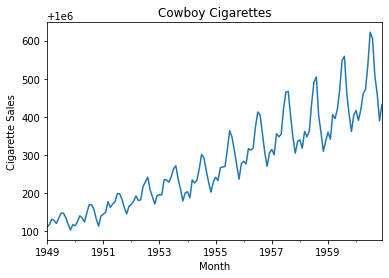

In [23]:
plt.title('Cowboy Cigarettes')
plt.ylabel('Cigarette Sales')
y.plot()

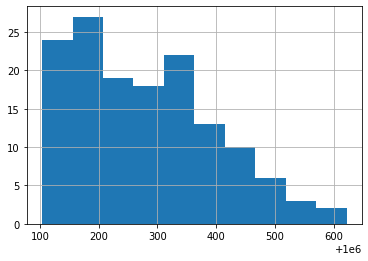

In [24]:
y.hist()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One often used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [25]:
y_log = np.log(y)
y_log.head()

Month
1949-01-31    13.815623
1949-02-28    13.815629
1949-03-31    13.815643
1949-04-30    13.815640
1949-05-31    13.815632
Freq: M, Name: #CigSales, dtype: float64


When you plot this, you can see how the variance in our data now remains contant over time.

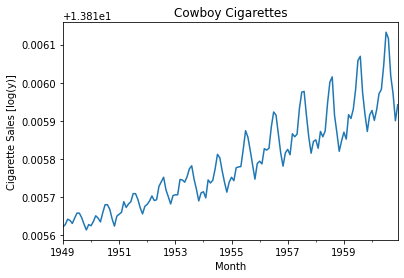

In [26]:
plt.title('Cowboy Cigarettes')
plt.ylabel('Cigarette Sales [log(y)]')
y_log.plot()

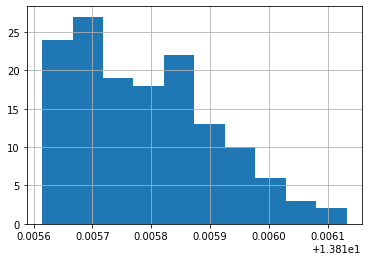

In [27]:
y_log.hist()

## Despite what the directions say below, this does NOT look like a constant variance nor a more uniformed distribution.
The variance and distribution appear to be unchanged.

This is most likely due to the fact that this dataset is a tweaked copy of another dataset (Passengers) from this [link](https://machinelearningmastery.com/power-transform-time-series-forecast-data-python/). This dataset was created by adding 1 million to each value in passenger to create the column #CigSales. Therefore, the log transformation does not work properly until the 1 million are removed. Example below.

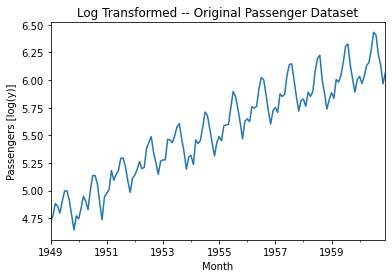

In [28]:
y_log_minus_mil = np.log(y-1000000)
plt.title('Log Transformed -- Original Passenger Dataset')
plt.ylabel('Passengers [log(y)]')
y_log_minus_mil.plot()

***Incorrect statement concerning variance provided by the activity.***
We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [29]:
y_log_diff = y_log.diff().dropna()
y_log_diff.head()

Month
1949-02-28    0.000006
1949-03-31    0.000014
1949-04-30   -0.000003
1949-05-31   -0.000008
1949-06-30    0.000014
Freq: M, Name: #CigSales, dtype: float64

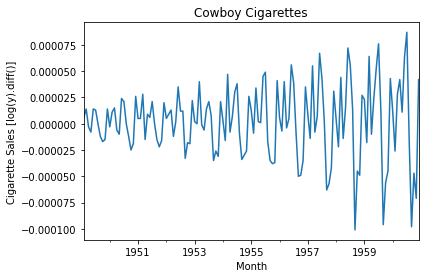

In [30]:
plt.title('Cowboy Cigarettes')
plt.ylabel('Cigarette Sales [log(y).diff()]')
y_log_diff.plot()

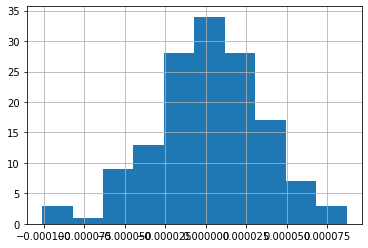

In [31]:
y_log_diff.hist()

In [32]:
kpss_test(y_log_diff)

Results of KPSS Test:
Test Statistic           0.023898
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/Users/tiffanyflor/.pyenv/versions/3.8.2/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


**Technicality in the activity directions. In reality, I would ensure a much larger p-value before accepting this dataset as one I'm okay accepting as stationary. Upon visual inspection there is clearly time-dependent variance.**<br>
Activity directions state:<br>
Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### Trial the BoxCox Transformation on Passenger Dataset
It will select the appropriate transformation.

Lambda: 0.148023


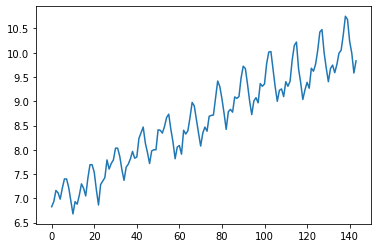

In [33]:
from scipy.stats import boxcox

y_boxcox, lam = boxcox(y-1000000)
print('Lambda: %f' % lam)
plt.plot(y_boxcox)

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [34]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model

In [35]:
# Make a function to find the MSE of a single ARIMA model
def evaluate_arima_model(data, arima_order):
    # split data into train and test, get 80% index
    # since split is used later as an index, it must be declared an integer
    split=int(len(data)*0.8)
    
    # train (80%) and test (20%) variables
    train, test = data[0:split], data[split:len(data)]
    past = [x for x in train]
    
    # make predictions
    predictions = list()
    for i in range(len(test)): #timestep-wise comparison between test data and one-step prediction ARIMA model
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
        
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    
    # return the error
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [36]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float('inf'), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for Mean Squared Error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA{} MSE={}'.format(order, mse))
                except:
                    continue
    return print('Best ARIMA{} MSE={}'.format(best_cfg, best_score))

In [37]:
# Choose a couple of values to try for each parameter: p_values, d_values, q_values
p_values = [x for x in range(0,3)]
d_values = [x for x in range(0,3)]
q_values = [x for x in range(0,3)]

In [38]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings('ignore') # not the best practice, but avoids confusion
evaluate_models(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=3.8430099868868486e-08
ARIMA(0, 0, 1) MSE=1.133031587015945e-08
ARIMA(0, 1, 0) MSE=2.793090250032919e-09
ARIMA(0, 1, 1) MSE=2.5037698462959653e-09
ARIMA(0, 1, 2) MSE=2.8376006295445675e-09
ARIMA(0, 2, 0) MSE=3.76804752220933e-09
ARIMA(0, 2, 1) MSE=3.415379619954952e-09
ARIMA(0, 2, 2) MSE=3.0841662574188027e-09
ARIMA(1, 0, 0) MSE=2.7563707872469676e-09
ARIMA(1, 0, 1) MSE=2.4558129035395544e-09
ARIMA(1, 0, 2) MSE=2.66548925808025e-09
ARIMA(1, 1, 0) MSE=2.531937213988432e-09
ARIMA(1, 1, 1) MSE=2.7104727799872614e-09
ARIMA(1, 2, 0) MSE=3.752602751680987e-09
ARIMA(2, 0, 0) MSE=2.4663586138786143e-09
ARIMA(2, 0, 1) MSE=2.486295642470628e-09
ARIMA(2, 1, 0) MSE=2.4476790613989505e-09
ARIMA(2, 1, 1) MSE=2.2289744453155192e-09
ARIMA(2, 1, 2) MSE=3.2794391574988316e-09
ARIMA(2, 2, 0) MSE=3.757346929616704e-09
ARIMA(2, 2, 2) MSE=4.539454625305923e-09
Best ARIMA(2, 1, 1) MSE=2.2289744453155192e-09


So the best p, d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [39]:
p = 2
d = 1
q = 1
model = ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

We can take a look at a summary of the model this library has built around our data.

In [40]:
# Call summary() on model_fit
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.#CigSales   No. Observations:                  143
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1263.116
Method:                       css-mle   S.D. of innovations              0.000
Date:                Fri, 15 Jan 2021   AIC                          -2516.233
Time:                        21:53:37   BIC                          -2501.418
Sample:                    02-28-1949   HQIC                         -2510.213
                         - 12-31-1960                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.624e-06   5.06e-07      5.184      0.000    1.63e-06    3.62e-06
ar.L1.D.#CigSales     0.4681      0.156      3.003      0.003       0.163       0.774
ar.L2.D.#CigSales    -0.2640      0.109     -2.413      0.016      -0.478      -0.050
ma.L1.D.#CigSales    -0.8693        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8866           -1.7326j            1.9463           -0.1747
AR.2            0.8866           +1.7326j            1.9463            0.1747
MA.1            1.1504           +0.0000j            1.1504            0.0000
-----------------------------------------------------------------------------
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

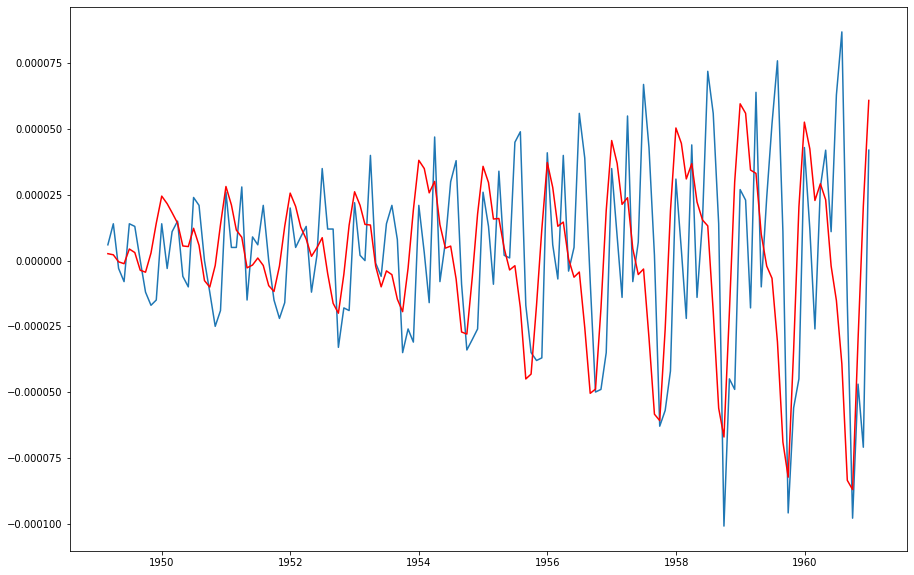

In [41]:
# Call figure() and plot() on the plt
plt.figure(figsize=(15,10))
plt.plot(y_log.diff())
plt.plot(model_fit.predict(), color='red')

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

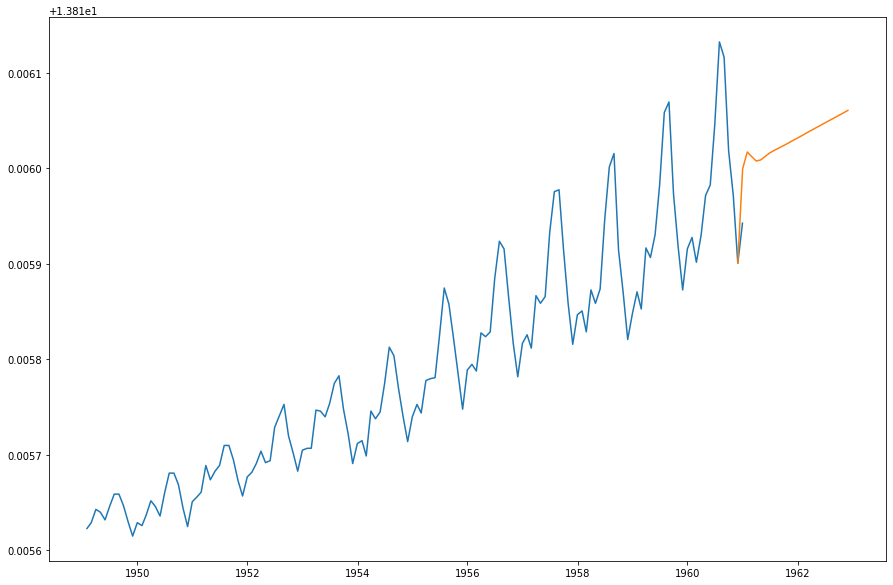

In [42]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
date_range = pd.date_range(y_log.index[-1], periods=forecast_period,
                          freq='MS').strftime('%Y-%m-%d').tolist()

# Convert that range into a dataframe that includes your predictions
future_months = pd.DataFrame(date_range, columns=['Month'])
# Convert the 'Month' column to datetime object
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace=True)
future_months['Prediction'] = forecast[0]

# Plot your future predictions
plt.figure(figsize=(15,10))
plt.plot(y_log)
plt.plot(y_log['Nov 1960'].append(future_months['Prediction']))
plt.show()

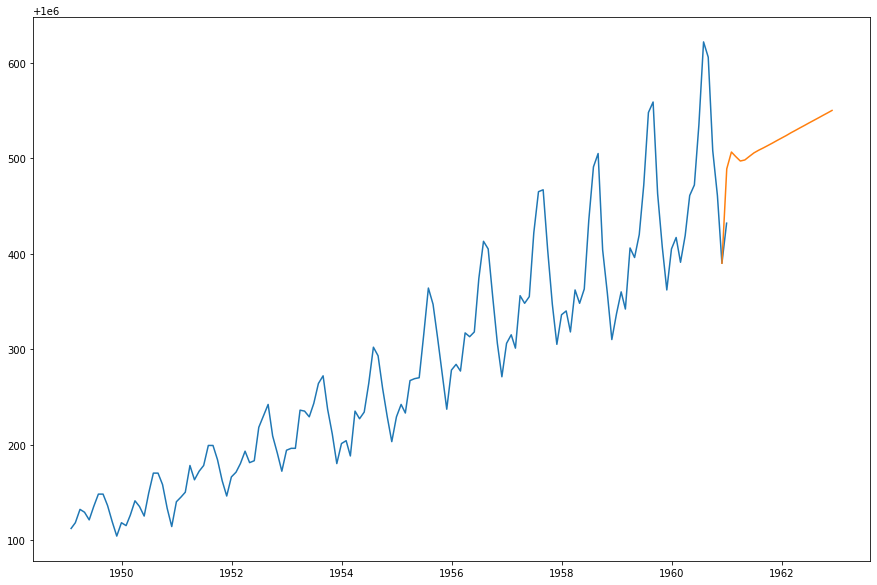

In [43]:
# Now plot the original variable y
# Use the same functions as before
plt.figure(figsize=(15,10))
plt.plot(y)
plt.plot(np.exp(y_log['Nov 1960'].append(future_months['Prediction'])))
plt.show()

## Auto Arima
I was not satisfied with the results provided from this activity as it merely provided an average for the future estimates.
So, using the original data, I utilized auto_arima to explore how well it could fit the data that is correctly treated as seasonal AND that is properly turned into a stationary dataset.

In [44]:
#!pip install pmdarima
from pmdarima import auto_arima
orig_y_dataset = np.log(y-1000000)
stepwise_model = auto_arima(orig_y_dataset, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-481.893, Time=0.84 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-434.830, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-474.813, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-483.371, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-449.978, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-481.906, Time=0.85 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-481.956, Time=1.37 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-477.399, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-479.902, Time=1.67 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-467.553, Time=0.20 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-481.610, Time=0.71 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-481.484, Time=0.36 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-479.399, Time=0.75 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-481.421, Time=0.66 sec

Best model:  ARIMA

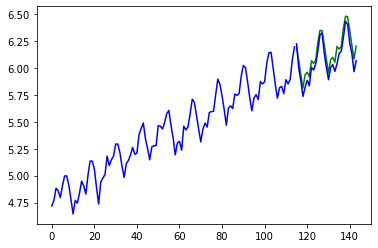

In [52]:
split=int(len(orig_y_dataset)*0.8)
train, test = orig_y_dataset[0:split], orig_y_dataset[split:len(orig_y_dataset)]

model = auto_arima(train, seasonal=True, m=12)


# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:split], train, c='blue')
plt.plot(x[split:], forecasts, c='green')
#plt.plot(x[split:], test, c='blue')
plt.show()

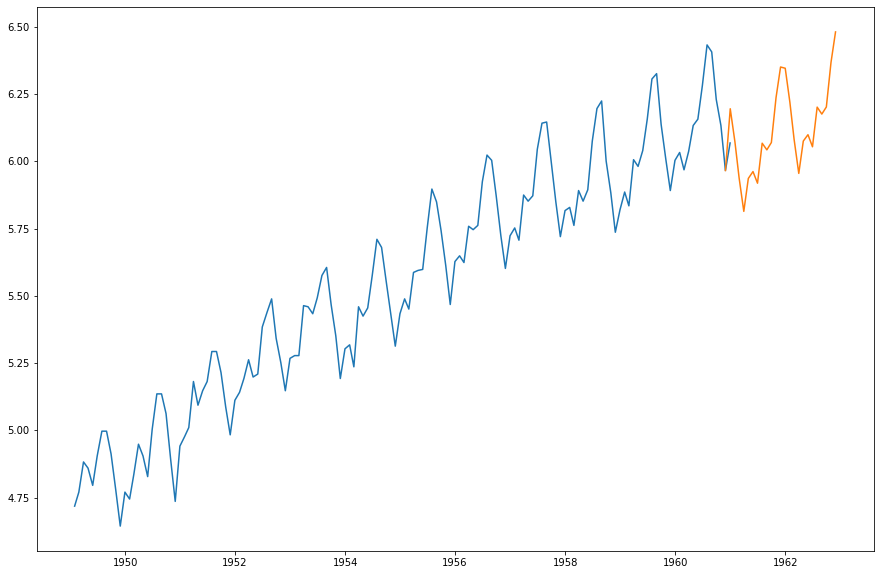

In [62]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
date_range = pd.date_range(orig_y_dataset.index[-1], periods=forecast_period,
                          freq='MS').strftime('%Y-%m-%d').tolist()

# Convert that range into a dataframe that includes your predictions
future_months = pd.DataFrame(date_range, columns=['Month'])
# Convert the 'Month' column to datetime object
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace=True)
## FIX ThiS
future_months['Prediction'] = model.predict(forecast_period)

# Plot your future predictions
plt.figure(figsize=(15,10))
plt.plot(orig_y_dataset)
plt.plot(orig_y_dataset['Nov 1960'].append(future_months['Prediction']))
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 